In [92]:
import pandas as pd
import numpy as np

import itertools

from os import listdir

from sklearn import metrics
from scipy import stats, special

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import CenteredNorm
%matplotlib inline

In [2]:
def merge_results_frames(df,df2):
    for idx,r in df.iterrows():
        g = r['gamma']
        p = r['bias']
        for col in df.columns:
            if col == 'gamma' or col == 'bias':
                continue
            df.loc[(df['gamma']==g) & (df['bias']==p),col]+=df2.loc[(df2['gamma']==g) & (df2['bias']==p),col]

def str2list(strarray):
    return [float(x) for x in strarray.strip('[] ').split()]

def df_str2list(df):
    for col in df.columns:
        if col == 'gamma' or col == 'bias':
            continue
        df[col] = df[col].apply(str2list)

In [145]:
def expand_shared_properties_in_dict(df):
    dictall = {}
    for _,row in df.iterrows():
        for col in df.columns:
            if col in ['gamma','bias']:
                rowlist = [row[col]]*len(row['Derrida'])
            else:
                rowlist = row[col]
            if col in dictall:
                dictall[col] += rowlist
            else:
                dictall[col] = rowlist.copy()
    return dictall

def append_extra_columns(dictall):
    dfall = pd.DataFrame(dictall)

    dfall['entropy'] = -(dfall['bias']*np.log(dfall['bias']))-((1-dfall['bias'])*np.log(1-dfall['bias']))
    dfall['variance'] = dfall['bias']*(1-dfall['bias'])

    dfall['avgS']=dfall['avgKe']-dfall['avgKc']
    dfall['avgSe']=3.33*dfall['avgKe']*dfall['variance']
    dfall['avgSk']=2*dfall['avgK']*dfall['variance']
    dfall['regime']=(dfall['Derrida']>1).astype(int) - (dfall['Derrida']<1).astype(int)
    dfall['bve']=dfall['avgSe']/(2*dfall['avgK'])
    dfall['avgSe_sample']=3.33*dfall['avgKe']*dfall['bve']
    dfall['avgKe_ent']=dfall['avgKe']*dfall['entropy']
    dfall['avgH'] = -dfall['avgP']*np.log(dfall['avgP'])-(1-dfall['avgP'])*np.log(1-dfall['avgP'])
    dfall['avgV'] = (1-dfall['avgP'])*dfall['avgP']
    
    return dfall

In [55]:
REGENERATE_DATA=False # takes a couple of minutes to regenerate data frame from individual csv files
results_dir_dict={20:'Results20/',50:'Results50/',100:'Results100/',200:'Results200/'}
if REGENERATE_DATA:
    results_dir_dict={20:'Results20/',50:'Results50/',100:'Results100/',200:'Results200/'}
    dfall = pd.DataFrame()
    for N,results_dir in results_dir_dict.items():
        first_in_N = True
        for filename in listdir(results_dir):
            if first_in_N:
                df = pd.read_csv(results_dir+filename)
                df_str2list(df)
                first_in_N = False
            else:
                df2 = pd.read_csv(results_dir+filename)
                df_str2list(df2)
                merge_results_frames(df,df2)
        dictall = expand_shared_properties_in_dict(df)
        dfallN = append_extra_columns(dictall)
        dfallN['N']=N
        dfall = pd.concat([dfall,dfallN],axis=0)
    dfall.to_csv('full_RBN_data.csv')           
else:
    dfall=pd.read_csv('full_RBN_data.csv')
Nvals = results_dir_dict.keys()
dfall['gamma'] = dfall['gamma'].round(2) # to fix some entries recorded, e.g., like 2.100000005
dfall['bias'] = dfall['bias'].round(2)
# shuffle data
dfall=dfall.sample(frac=1.0)

dfall

,Unnamed: 0,gamma,bias,Derrida,avgK,medK,avgKe,medKe,avgKc,medKc,...,avgS,avgSe,avgSk,regime,bve,avgSe_sample,avgKe_ent,avgH,avgV,N
121241,13241,1.8,0.35,0.960,2.37,1.0,1.382079,1.0,0.375329,0.0,...,1.006749,1.047028,1.07835,-1,0.220892,1.016616,0.894822,0.646787,0.227180,200
108736,736,1.5,0.10,0.569,3.23,2.0,1.342949,0.0,0.775304,0.0,...,0.567644,0.402482,0.58140,-1,0.062304,0.278623,0.436570,0.327416,0.090851,200
81031,9031,1.7,0.25,0.991,2.50,1.0,1.439570,1.0,0.406924,0.0,...,1.032646,0.898832,0.93750,-1,0.179766,0.861758,0.809521,0.570387,0.191176,100
70507,34507,2.4,0.30,0.590,1.18,1.0,0.595000,1.0,0.040000,0.0,...,0.555000,0.416083,0.49560,-1,0.176307,0.349325,0.363464,0.595073,0.202588,50
98070,26070,2.2,0.15,0.563,2.04,1.0,0.820028,0.0,0.295653,0.0,...,0.524375,0.348163,0.52020,-1,0.085334,0.233021,0.346633,0.423538,0.127834,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,73,1.5,0.05,0.225,3.50,1.0,1.227531,0.0,0.962943,0.0,...,0.264587,0.194165,0.33250,-1,0.027738,0.113383,0.243684,0.198866,0.047607,20
100401,28401,2.2,0.45,1.010,2.07,1.0,1.329823,1.0,0.273070,0.0,...,1.056753,1.096007,1.02465,1,0.264736,1.172333,0.915103,0.688253,0.247557,100
35176,35176,2.4,0.35,0.617,1.65,1.0,0.786563,0.5,0.149062,0.0,...,0.637500,0.595880,0.75075,-1,0.180570,0.472958,0.509257,0.609226,0.209227,20
33048,33048,2.4,0.10,0.345,1.60,1.0,0.562048,0.0,0.182361,0.0,...,0.379688,0.168446,0.28800,-1,0.052639,0.098521,0.182712,0.363767,0.104398,20


In [84]:
def kmean(gamma,cutoff=None):
    if cutoff is None:
        return special.zeta(gamma-1)/special.zeta(gamma)
    else:
        ks = np.arange(1,cutoff+1).astype(float)
        return np.sum(ks**(1-gamma)) / np.sum(ks**(-gamma))
        #return np.sum([k**(1-gamma) for k in ks]) / np.sum([k**(-gamma) for k in ks])
    
print(kmean(2.1,cutoff=15))

1.9674221545883677


C:\Users\jcroz\AppData\Local\Temp\ipykernel_17812\754579210.py:7: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(xrange,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xrange],'k--')


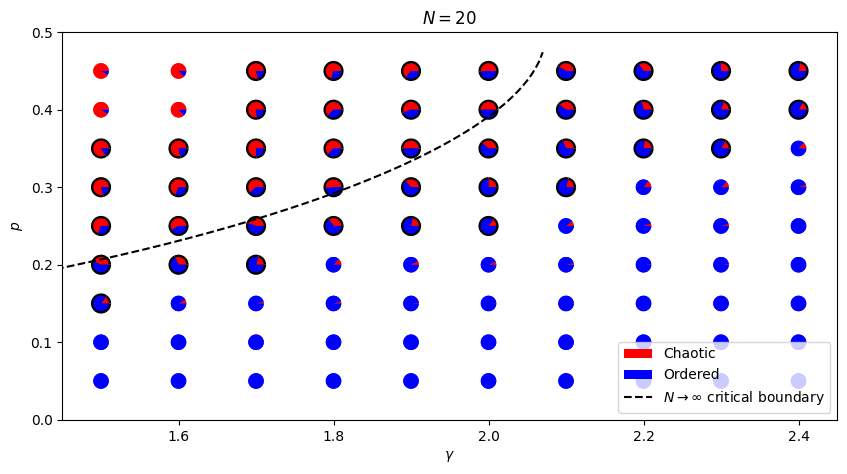

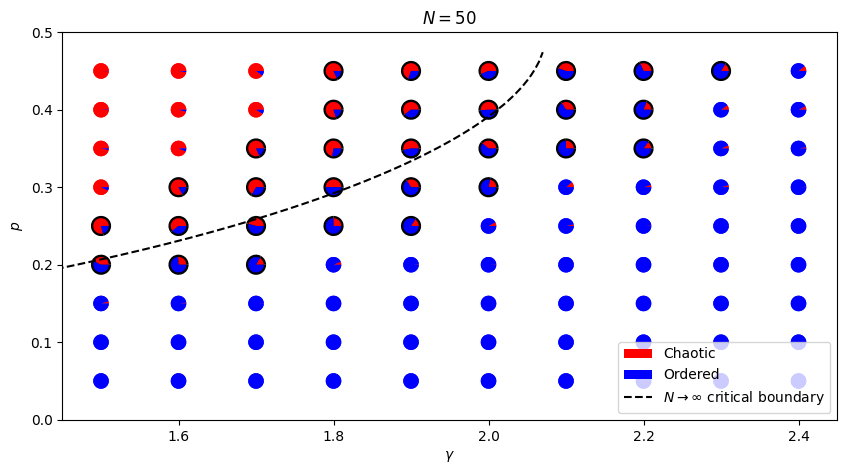

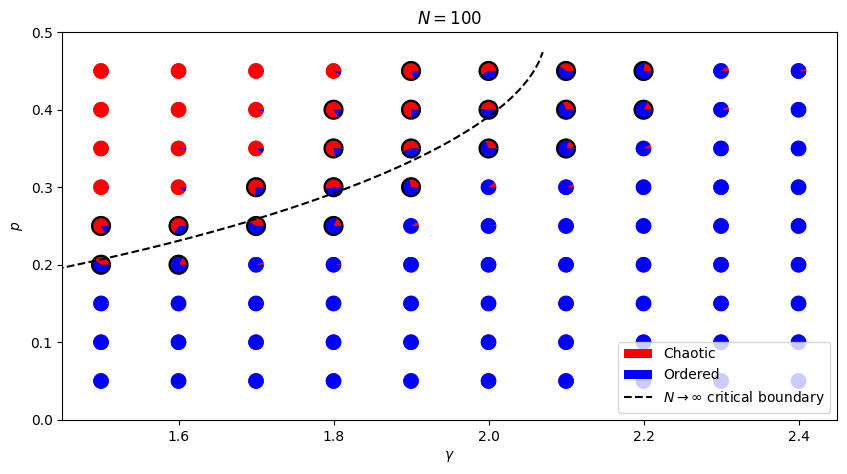

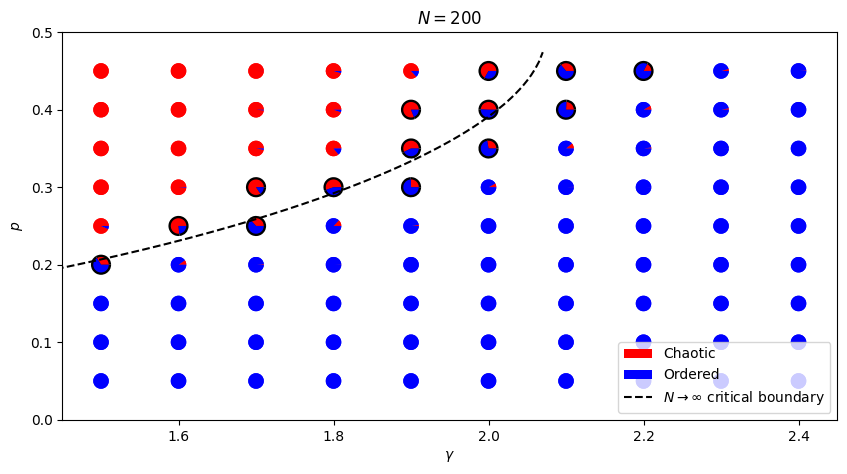

In [99]:
biases = np.arange(0.05,0.5,0.05).round(2)
gammas = np.arange(1.5,2.5,0.1).round(2)
for N in Nvals:
    fig, ax = plt.subplots(figsize=(10, 10),facecolor='white')
    
    xrange = np.arange(1.4, 2.6, 0.005)
    ax.plot(xrange,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xrange],'k--') 
    
    for g,p in itertools.product(gammas,biases):
        g=g.round(2)
        p=p.round(2)
        ones = (dfall[(dfall['N'] == N) & (dfall['gamma'] == g) & (dfall['bias'] == p)]['Derrida']>1).mean()
        ax.pie([ones, 1-ones], center=(g, p), radius=0.01, colors=['r', 'b'], frame=True)
        if ones > 0.85 or ones < 0.15:
            ax.pie([ones, 1-ones], center=(g, p), radius=0.01, colors=['r', 'b'], frame=True)
        else:
            ax.pie([ones, 1-ones], center=(g, p), radius=0.013, colors=['k', 'k'], frame=True)
            ax.pie([ones, 1-ones], center=(g, p), radius=0.01, colors=['r', 'b'], frame=True)
        ax.set_xlim(1.45,2.45)
        ax.set_ylim(0,0.5)
        #ones = [derrida > 1 for derrida in row['Derrida']]
        

    legend_elements = [Patch(facecolor='r', label='Chaotic'), Patch(facecolor='b', label='Ordered'), Line2D([0],[0],color='k',linestyle='--',label=r'$N\rightarrow\infty$ critical boundary')]
    plt.title(f'$N=${N}')
    plt.xlabel('$\gamma$')
    plt.ylabel('$p$')
    ax.legend(handles=legend_elements, loc='lower right')
    plt.show()

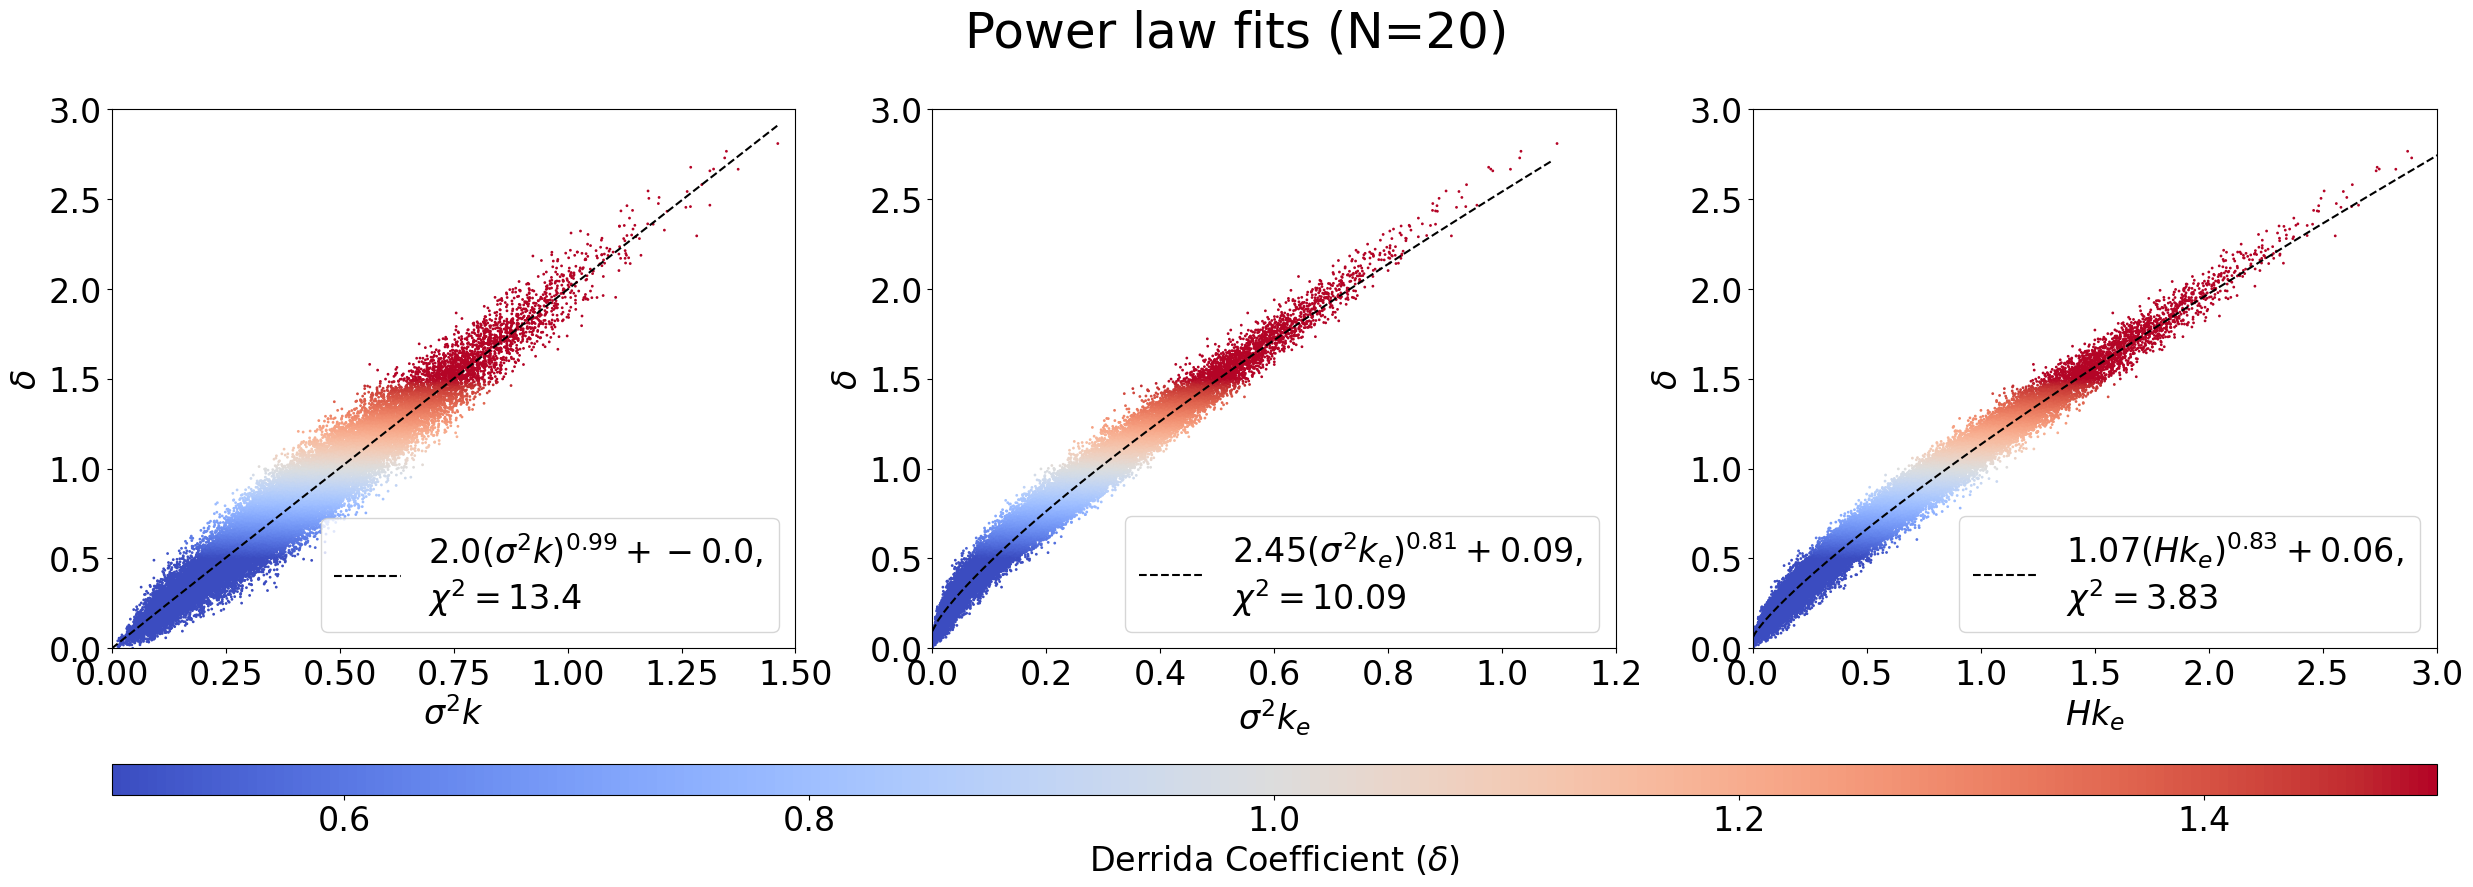

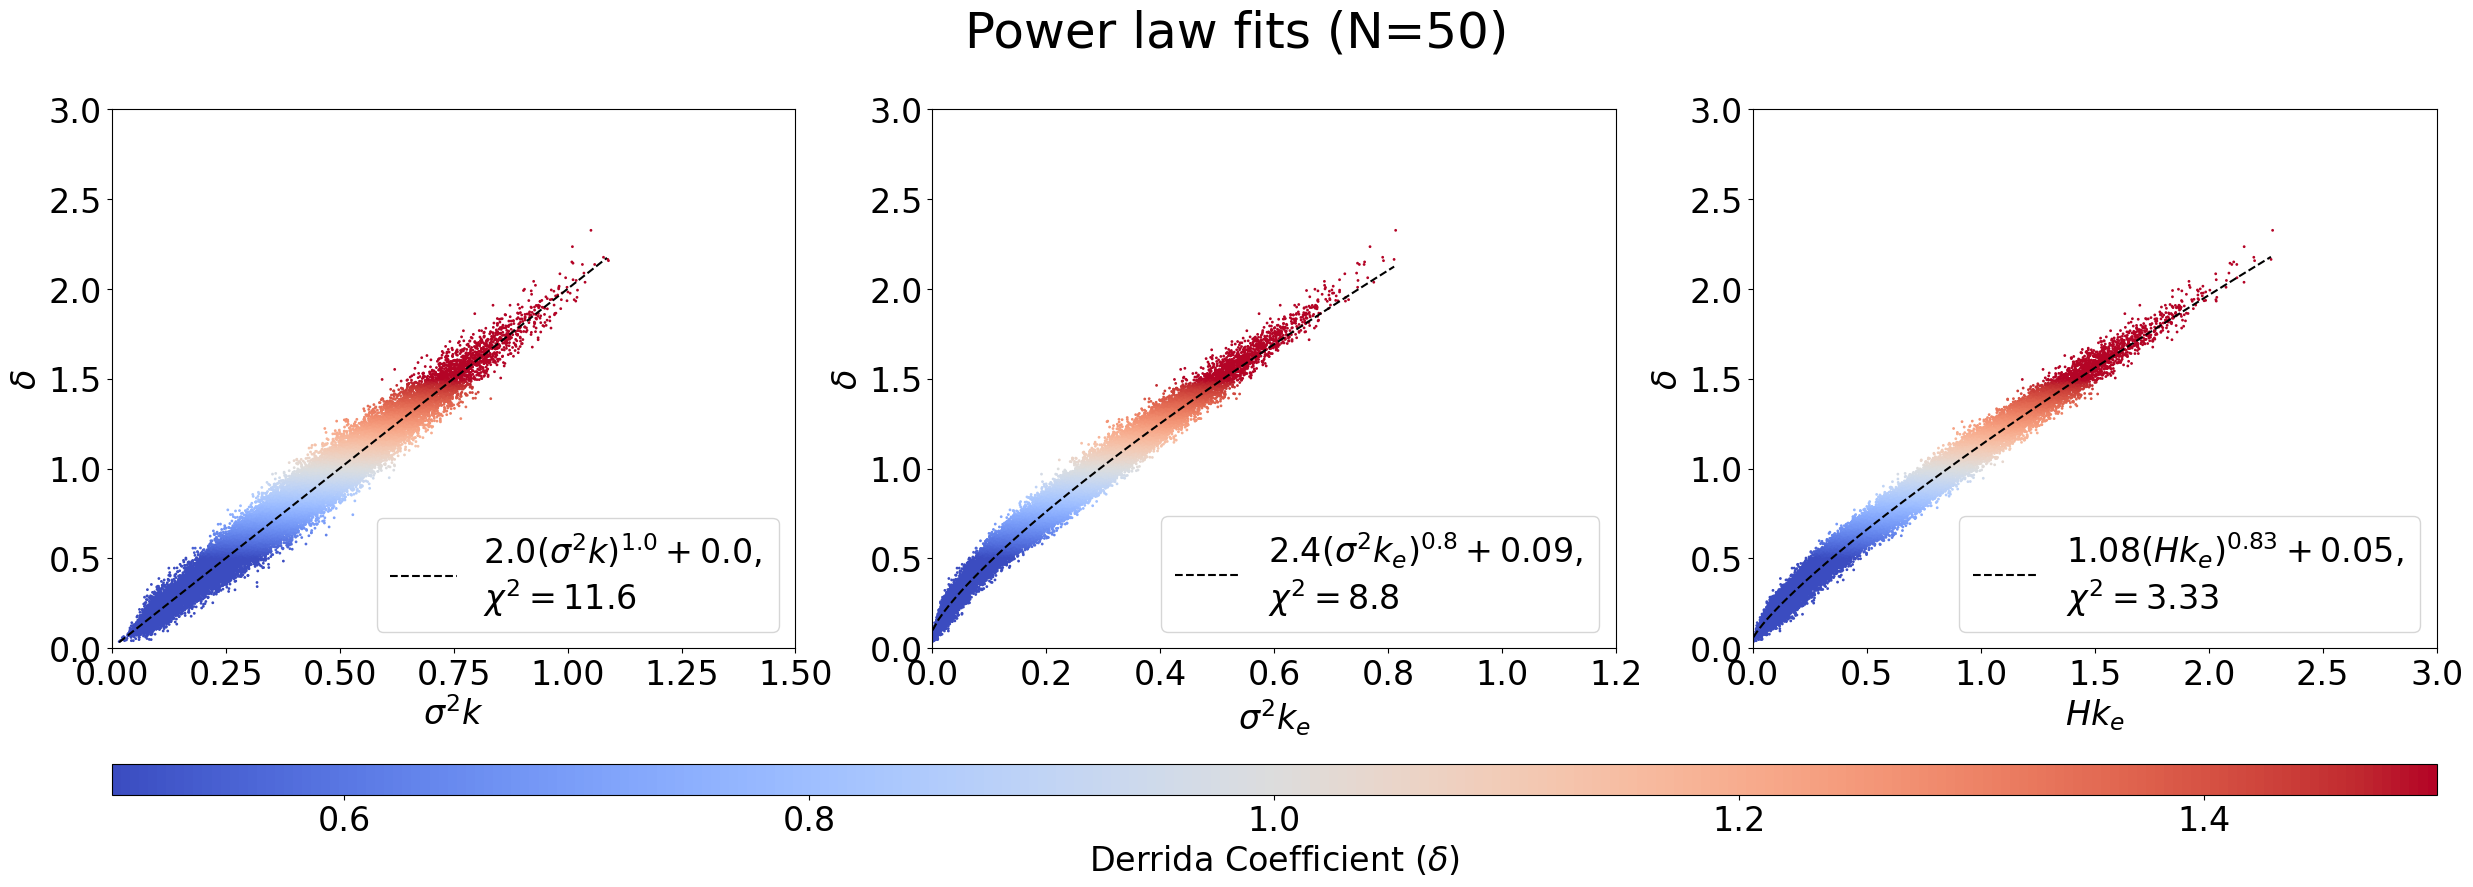

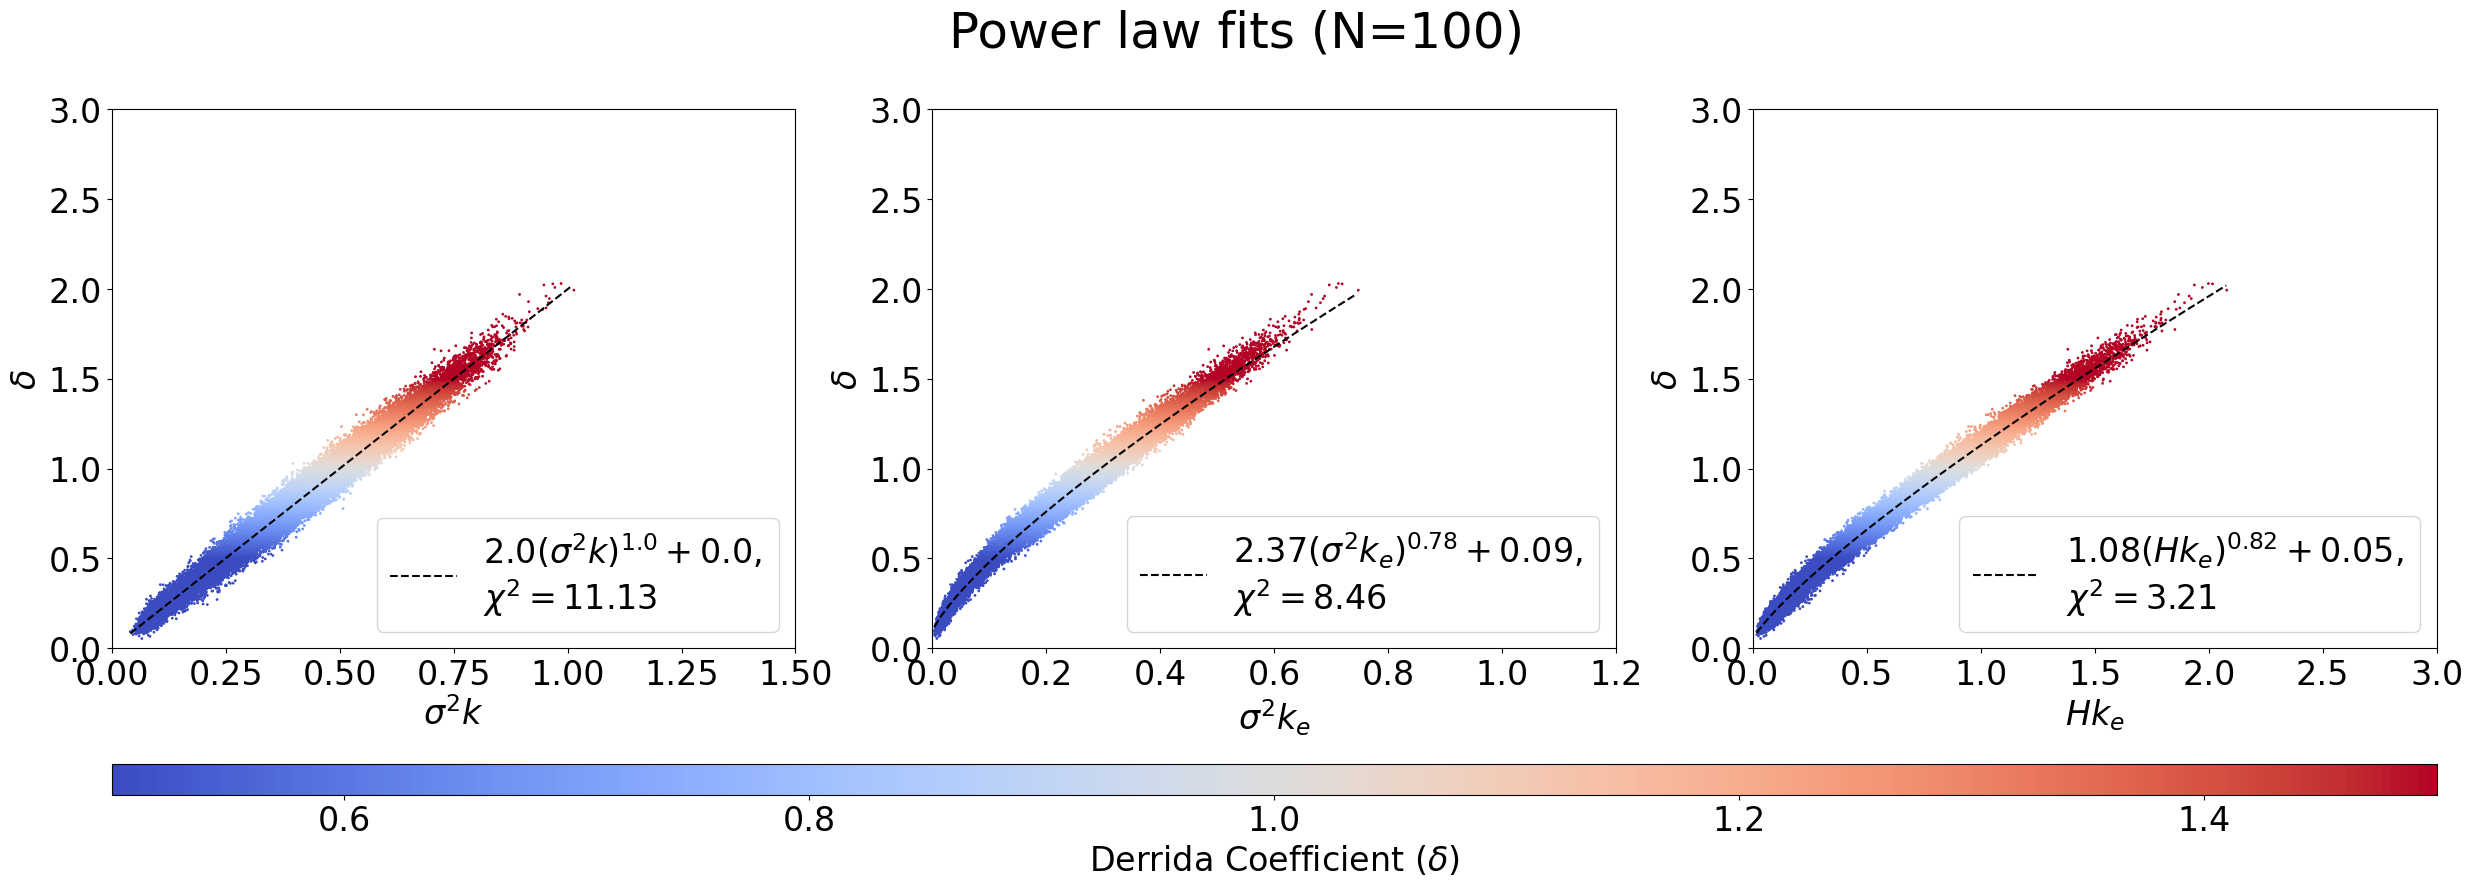

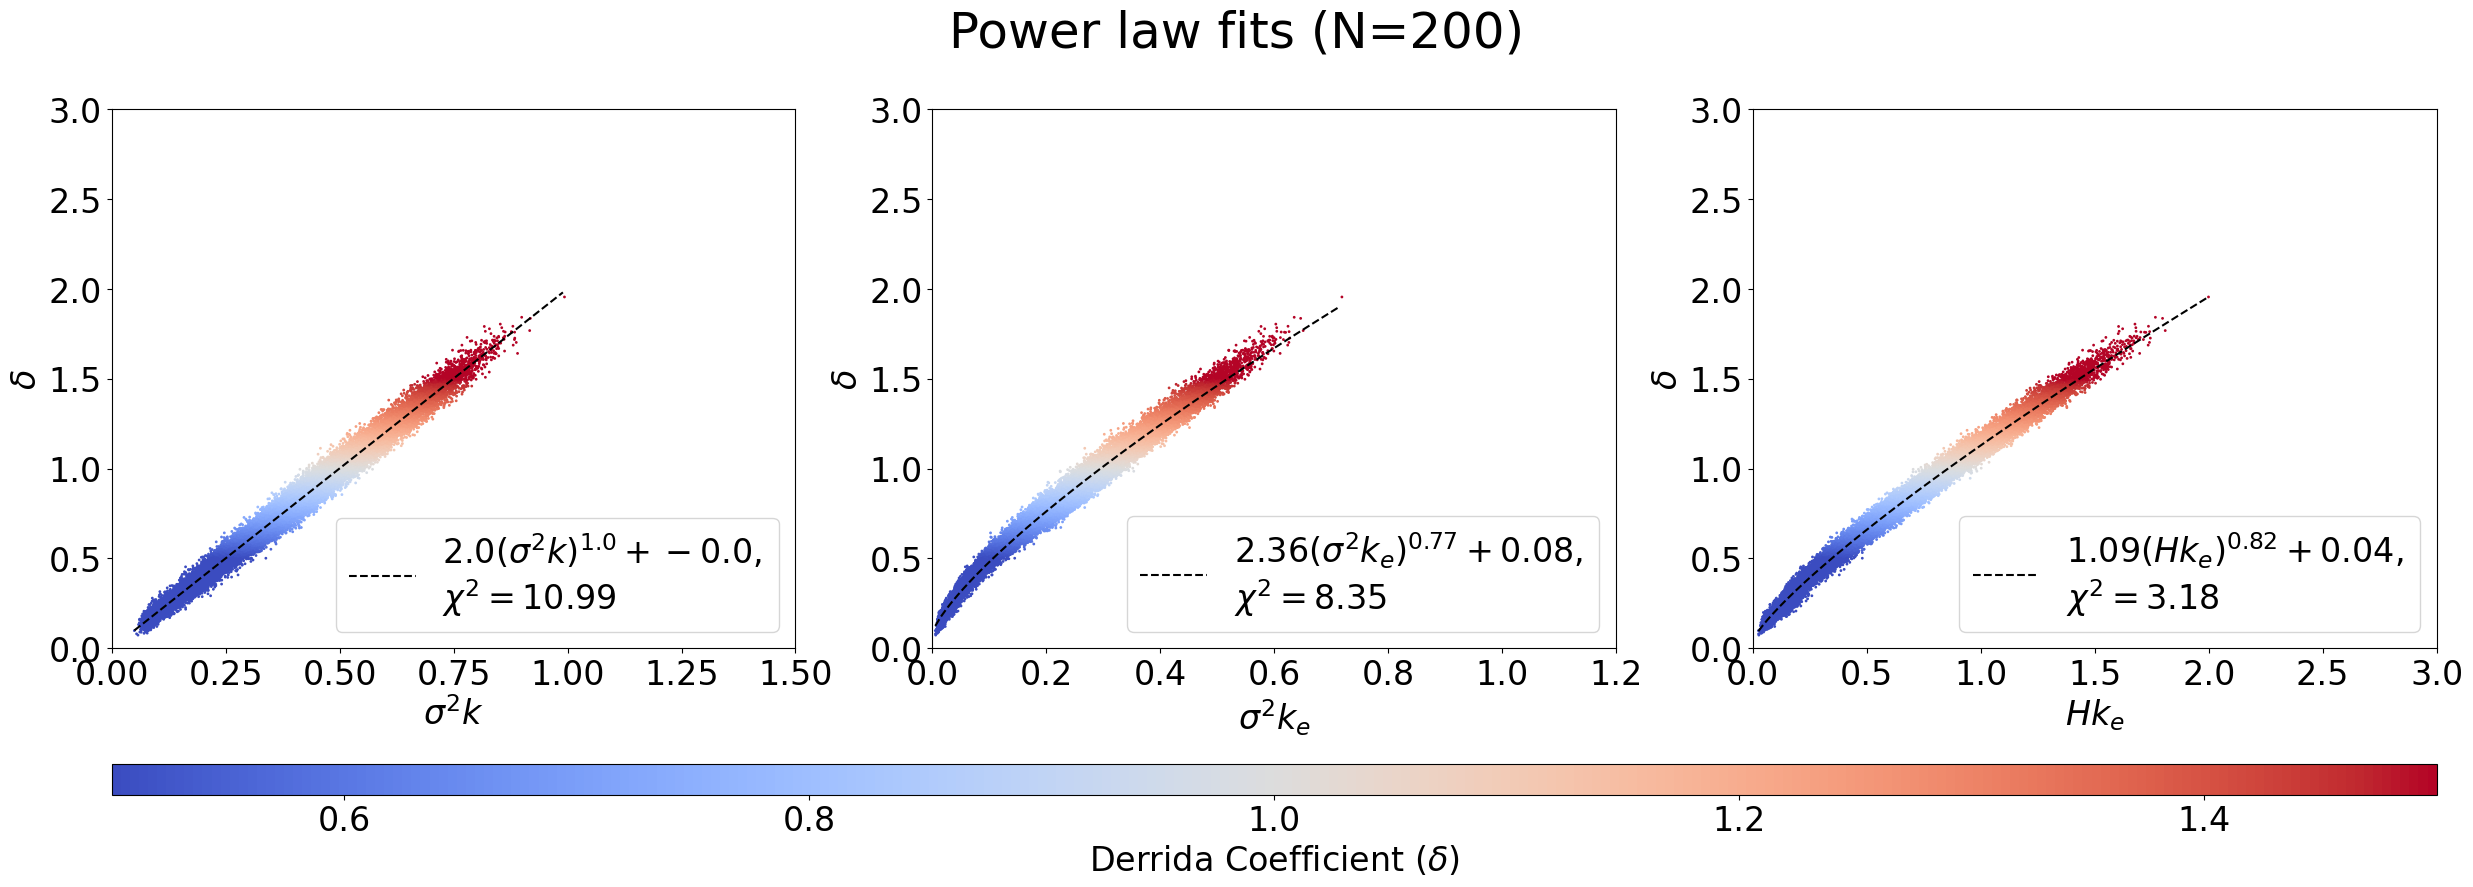

In [178]:
from scipy.optimize import curve_fit
def powerlaw(x,c,m,b):
    return c*x**m+b

def chisqr(x,y,f):
    mask = (y!=0) & np.isfinite(x) & np.isfinite(y)
    xm = x[mask]
    ym = y[mask]
    return np.nanmean((f(xm)-ym)**2 / ym)

Nvals_test=[20,50]
fs = 24
for N in Nvals:
    dfN = dfall[dfall['N']==N]
    
    fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
    cmap = plt.cm.get_cmap('coolwarm')#.reversed()
    x=dfN['avgK']*dfN['avgV']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=powerlaw(xfit,c,m,b)
    chi2 = chisqr(x,dfN['Derrida'],lambda xi: powerlaw(xi,c,b,m))
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(\sigma^2 k)^{mstr}+{np.round(b,2)}$, \n$\chi^2={np.round(chi2,2)}$'
    ax[0].plot(xfit,yfit,'k--', label=label)
    sc=ax[0].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[0].set_xlabel("$\sigma^2 k$",fontsize=fs)
    ax[0].set_ylabel("$\delta$",fontsize=fs)
    ax[0].tick_params(axis='both', which='major', labelsize=fs)
    ax[0].legend(fontsize=fs, loc = 'lower right')
    ax[0].set_ylim(0,3)
    ax[0].set_xlim(0,1.5)
    
    x=dfN['avgKe']*dfN['avgV']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=powerlaw(xfit,c,m,b)
    chi2 = chisqr(x,dfN['Derrida'],lambda xi: powerlaw(xi,c,b,m))
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(\sigma^2 k_e)^{mstr}+{np.round(b,2)}$, \n$\chi^2={np.round(chi2,2)}$'
    ax[1].plot(xfit,yfit,'k--', label=label)
    sc=ax[1].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))    
    ax[1].set_xlabel("$\sigma^2 k_e$",fontsize=fs)
    ax[1].set_ylabel("$\delta$",fontsize=fs)
    ax[1].tick_params(axis='both', which='major', labelsize=fs)
    ax[1].legend(fontsize=fs, loc = 'lower right')
    ax[1].set_ylim(0,3)
    ax[1].set_xlim(0,1.2)
    
    x=dfN['avgKe']*dfN['avgH']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=powerlaw(xfit,c,m,b)
    chi2 = chisqr(x,dfN['Derrida'],lambda xi: powerlaw(xi,c,b,m))
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(Hk_e)^{mstr}+{np.round(b,2)}$, \n$\chi^2={np.round(chi2,2)}$'
    ax[2].plot(xfit,yfit,'k--',label=label)
    sc=ax[2].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[2].set_xlabel("$Hk_e$",fontsize=fs)
    ax[2].set_ylabel("$\delta$",fontsize=fs)
    ax[2].tick_params(axis='both', which='major', labelsize=fs)
    ax[2].legend(fontsize=fs, loc = 'lower right')
    ax[2].set_ylim(0,3)
    ax[2].set_xlim(0,3)
    
    cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
    cbar.ax.tick_params(axis='both',labelsize=fs)
    cbar.set_label('Derrida Coefficient ($\delta$)',fontsize=fs)
    plt.suptitle(f'Power law fits ({N=})',fontsize=fs*1.5)
    plt.show()